# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

## Bringing in Our Modeling Class from before

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [3]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [5]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical
subpipe_numerics = Pipeline(steps = [
    ('num_impute',SimpleImputer()),
    ('ss', StandardScaler())
])

subpipe_categoricals = Pipeline(steps =[
    ('cat_impute', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

### Selector!!!!

[This](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector) will return a callable list of columns

In [7]:
# Selector!

test = selector(dtype_include=object)

In [8]:
test(X)

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [9]:
CT = ColumnTransformer(transformers =[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat',subpipe_categoricals, selector(dtype_include=object))
], remainder = 'passthrough') 

In [10]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.


In [11]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.


In [12]:
# Create Dummy/Baseline


dummy_model_pipe = Pipeline(steps = [
    ('ct',CT),
    ('dummy', DummyClassifier(strategy = 'most_frequent'))
])

In [13]:
# Use the class with out dummy pipe
dummy_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001EB6E852D90>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                        

In [14]:
dummy_model_pipe.score(X_train,y_train)

0.6212574850299402

In [15]:
dummy_model_pipe.score(X_test, y_test)

0.600896860986547

In [16]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe,
    model_name ='dummy',
    X= X_test,
    y= y_test,
)

CV Results for `dummy` model:
            0.60079 ± 0.01428 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

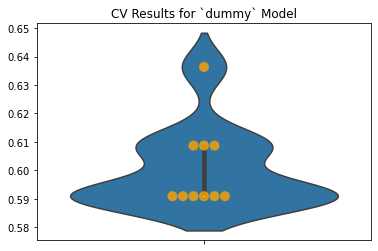

In [17]:
fig, ax = plt.subplots()

dummy_pipe.print_cv_summary()

dummy_pipe.plot_cv(ax = ax)

In [18]:
# Create FSM (First Simple Model)
fsm_model_pipe = Pipeline(steps = [
    ('ct',CT),
    ('fsm', LogisticRegression())
])

CV Results for `dummy` model:
            0.82451 ± 0.07107 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

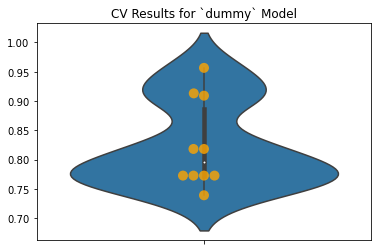

In [19]:
# Use the class with out logreg pipe
fsm_pipe = ModelWithCV(
    fsm_model_pipe,
    model_name ='dummy',
    X= X_test,
    y= y_test,
)
fig,ax = plt.subplots()

fsm_pipe.print_cv_summary()

fsm_pipe.plot_cv(ax = ax)

In [20]:
for name, model in model_list:
    loop_model_pipe = Pipeline(steps=[
        ('ct', CT),
        (name, model)
    ])
    
    loop_model_pipe.fit(X_train,y_train)
    
    loop_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_test,
        y=y_test)
    
    loop_pipe.print_cv_summary()

NameError: name 'model_list' is not defined

In [21]:
model_list = [('dummy',dum_model), ('logreg',lr_model), ('dtc',tree_model), ('gbc',GradientBoostingClassifier())]

NameError: name 'dum_model' is not defined

## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [ ]:
# rfc!

### Gradient Booster

In [ ]:
# gbc!

## Tuning and Cross-Validating

In [ ]:
# GridSearch?

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [ ]:
y_train.value_counts()

In [ ]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [ ]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [ ]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [ ]:
y_train_clean.value_counts()

In [ ]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

In [ ]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [ ]:
# imbpipe!

### Gridsearching

In [ ]:
# Seriously? Again?

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [ ]:
final_model = imb_pipe

In [ ]:
plot_confusion_matrix(final_model, X_test, y_test);

In [ ]:
y_hat = final_model.predict(X_test)

In [ ]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")

## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






